In [ ]:
# code for the energy data 

In [18]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat

# Step 1: Define path to folder containing the JSON files
json_folder_path = r'D:\05_05_2025\data\control_actions'

# Step 2: Read all JSON files and normalize into a single DataFrame
all_energy_data = []

for json_file in os.listdir(json_folder_path):
    if json_file.endswith('.json'):
        full_path = os.path.join(json_folder_path, json_file)
        with open(full_path, 'r') as file:
            try:
                json_data = json.load(file)
                json_data['source_file'] = json_file  # Track file origin
                df = pd.json_normalize(json_data)
                all_energy_data.append(df)
            except json.JSONDecodeError:
                print(f"Error decoding {json_file}")

# Combine all data
energy_df = pd.concat(all_energy_data, ignore_index=True)

# Step 3: Parse timestamps and clean
energy_df = energy_df.dropna(subset=['energy_data.timestamp'])
energy_df['timestamp'] = pd.to_datetime(energy_df['energy_data.timestamp'])
energy_df.set_index('timestamp', inplace=True)
energy_df.sort_index(inplace=True)

# Step 4: Define experiment start and end manually (adjust if needed)
experiment_start = pd.to_datetime("2025-05-05 13:38:00")  # <- actual start time
experiment_end = pd.to_datetime("2025-05-05 17:36:46")    # <- 6 hours later

# Filter to 6-hour experiment duration
experiment_df = energy_df.loc[experiment_start:experiment_end]

# Step 5: Convert time to minutes since experiment start
minutes_from_start = (experiment_df.index - experiment_start).total_seconds() / 60

# Step 6: Plot with high resolution
plt.figure(figsize=(10, 6), dpi=1000)
plt.plot(minutes_from_start, experiment_df['energy_data.total_energy'], linewidth=2)
plt.title('MPC: Time vs Energy')
plt.xlabel('Time (minutes)')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# code for the tmeps. 

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

temp_folder = r"D:\05_05_2025\data\temperatures"
experiment_start = pd.to_datetime("2025-05-05 13:37:46")
experiment_end = pd.to_datetime("2025-05-05 17:36:33")

temp_records = []

for filename in os.listdir(temp_folder):
    if filename.startswith('temps_2025-05-05') and filename.endswith('.json'):
        file_path = os.path.join(temp_folder, filename)
        with open(file_path, 'r') as file:
            try:
                data = json.load(file)
                if 'temperatures' in data and 'timestamp' in data:
                    flat_record = data['temperatures'].copy()
                    flat_record['timestamp'] = data['timestamp']
                    temp_records.append(flat_record)
            except json.JSONDecodeError:
                print(f"Could not decode {filename}")

if not temp_records:
    raise ValueError("No temperature records found. Check file names and structure.")

temp_df = pd.DataFrame(temp_records)

temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
temp_df.set_index('timestamp', inplace=True)
temp_df.sort_index(inplace=True)

temp_df = temp_df.loc[experiment_start:experiment_end]

temp_df['minutes_since_start'] = (temp_df.index - experiment_start).total_seconds() / 60

plt.figure(figsize=(14, 6), dpi=1000)
for col in [c for c in temp_df.columns if c not in ['TR3', 'BR1', 'minutes_since_start']]:
    plt.plot(temp_df['minutes_since_start'], temp_df[col], label=col)

# Add comfort zone
plt.axhspan(70, 80, color='green', alpha=0.1, label='Comfort Range (70–80°F)')

# Labeling
plt.title("MPC: Room Temperatures (05/05/2025)")
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# code for filtereed temps

In [20]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

temp_folder = r"D:\05_05_2025\data\temperatures"
experiment_start = pd.to_datetime("2025-05-05 13:37:46")
experiment_end = pd.to_datetime("2025-05-05 17:36:33")

temp_records = []

for filename in os.listdir(temp_folder):
    if filename.startswith('filtered_temps_2025-05-05') and filename.endswith('.json'):
        file_path = os.path.join(temp_folder, filename)
        with open(file_path, 'r') as file:
            try:
                data = json.load(file)
                if 'temperatures' in data and 'timestamp' in data:
                    flat_record = data['temperatures'].copy()
                    flat_record['timestamp'] = data['timestamp']
                    temp_records.append(flat_record)
            except json.JSONDecodeError:
                print(f"Could not decode {filename}")

if not temp_records:
    raise ValueError("No temperature records found. Check file names and structure.")

temp_df = pd.DataFrame(temp_records)

temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
temp_df.set_index('timestamp', inplace=True)
temp_df.sort_index(inplace=True)

temp_df = temp_df.loc[experiment_start:experiment_end]

temp_df['minutes_since_start'] = (temp_df.index - experiment_start).total_seconds() / 60

plt.figure(figsize=(14, 6), dpi=1000)
for col in [c for c in temp_df.columns if c not in ['TR3','BR1', 'minutes_since_start']]:
    plt.plot(temp_df['minutes_since_start'], temp_df[col], label=col)

# Add comfort zone
plt.axhspan(70, 80, color='green', alpha=0.1, label='Comfort Range (70–80°F)')

# Labeling
plt.title("MPC: Room Temperatures with Kalman Filter (05/05/2025)")
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (°F)")
plt.legend(loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

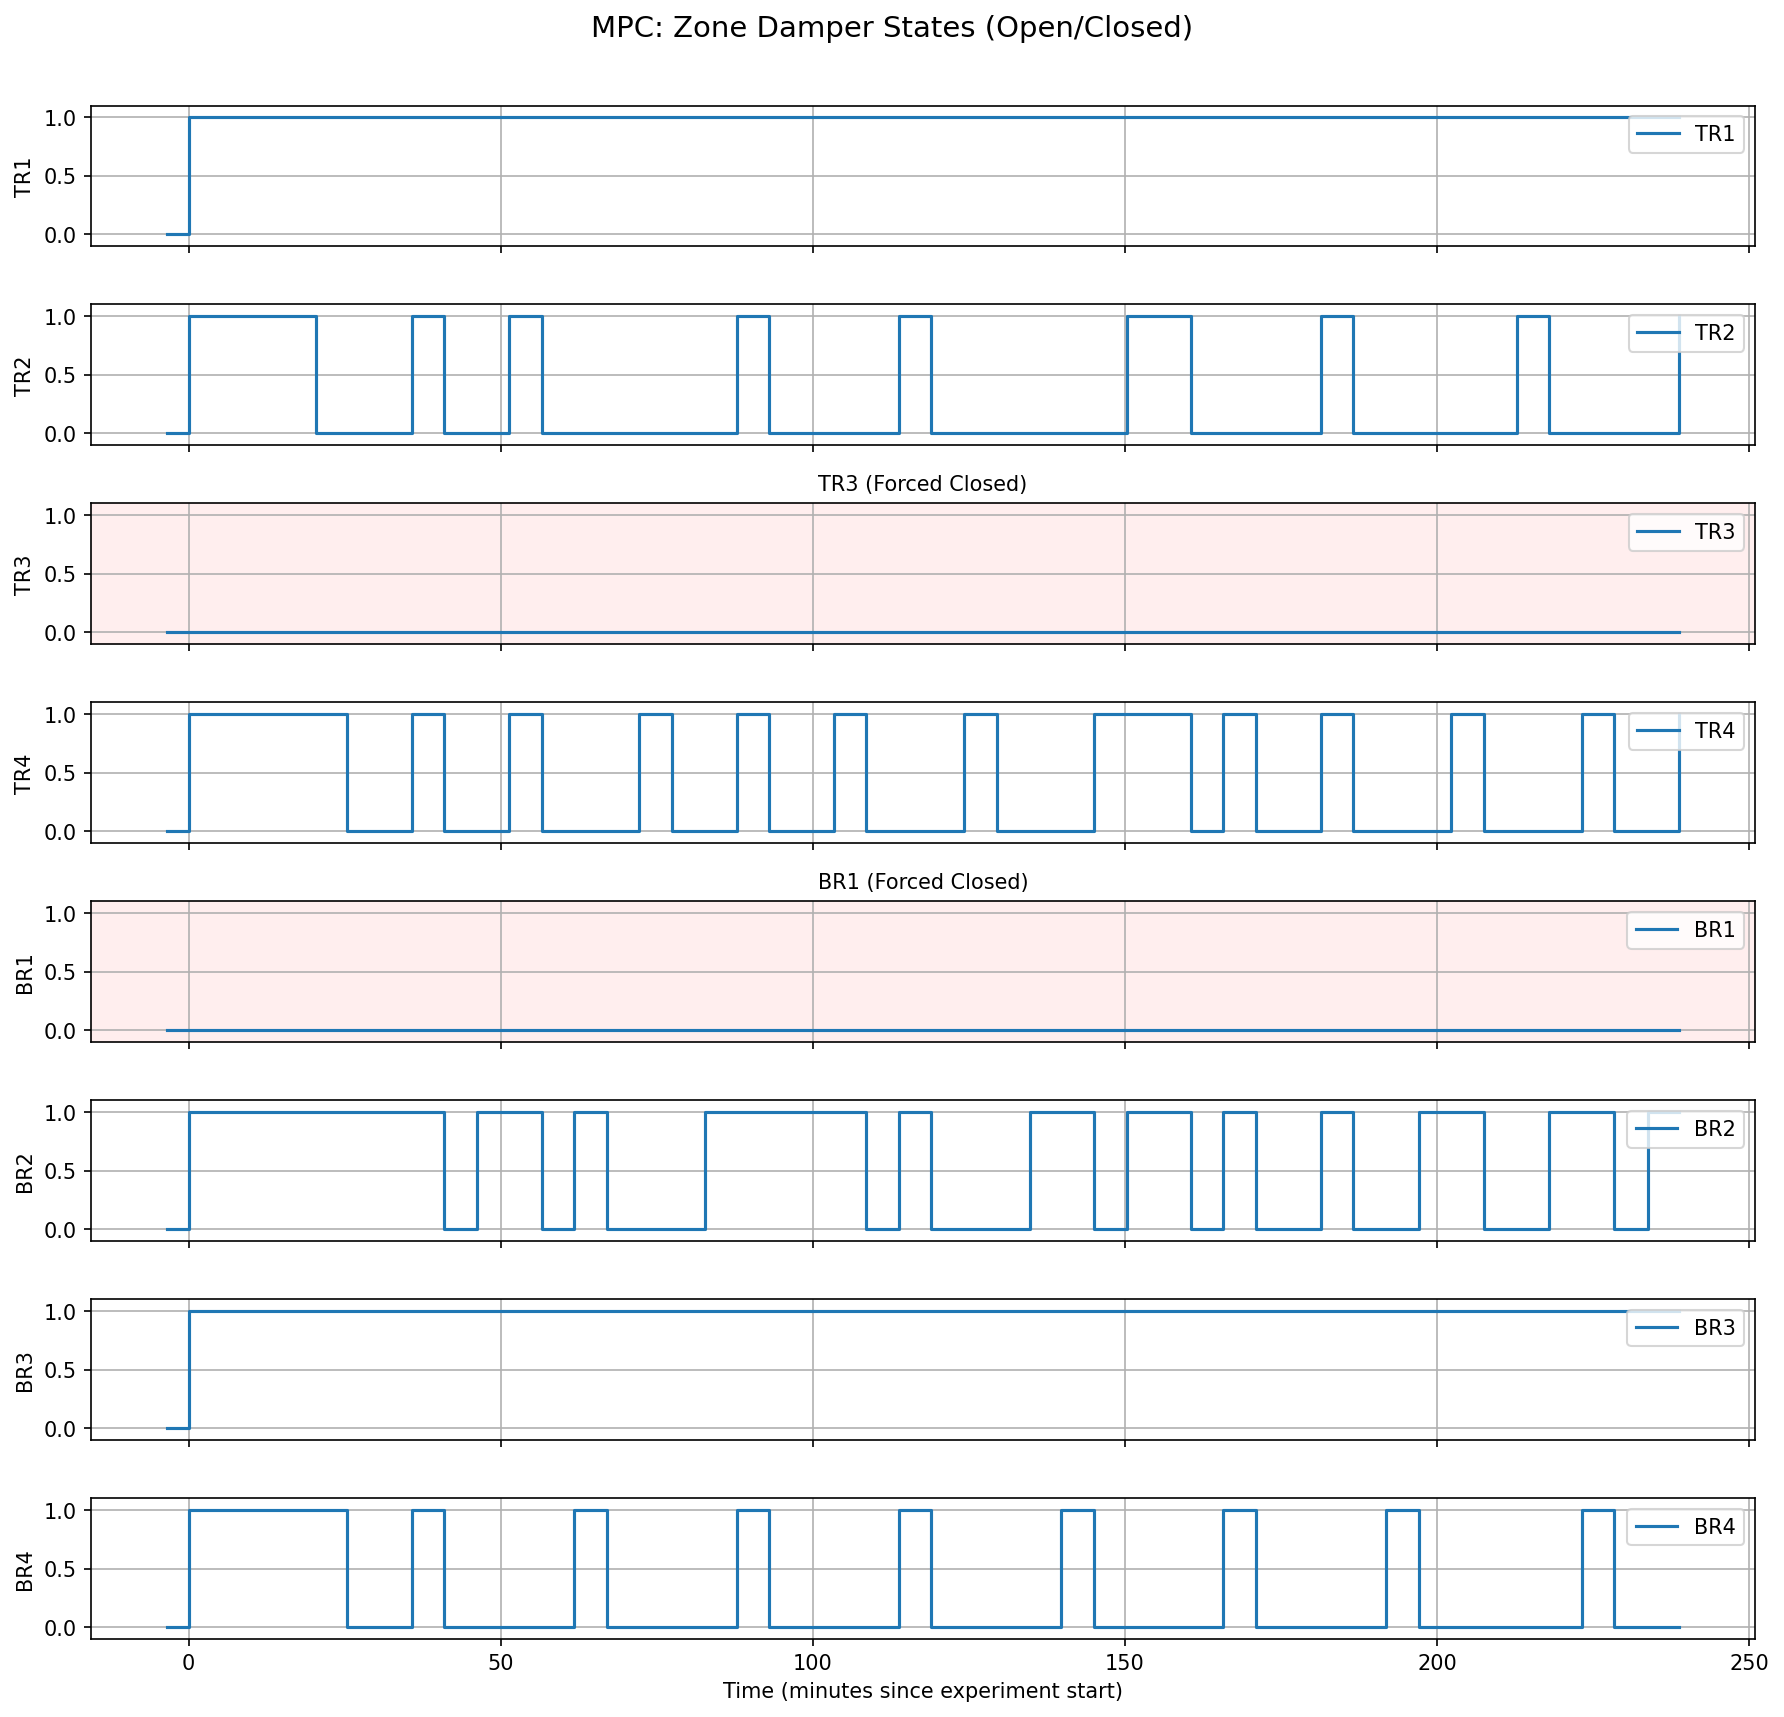

In [15]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
base_folder = r"D:\05_05_2025\data\control_actions"
experiment_start = pd.to_datetime("2025-05-05 13:37:48")
# ----------------------------

# Correct damper to zone mapping (from hardware_interface.py)
damper_to_zone = {
    0: "TR4",  # Damper 1
    1: "BR4",  # Damper 2
    2: "TR3",  # Damper 3
    3: "BR3",  # Damper 4
    4: "TR2",  # Damper 5
    5: "BR2",  # Damper 6
    6: "TR1",  # Damper 7
    7: "BR1"   # Damper 8
}

# -------- Load Damper Data ----------
damper_records = []
for file in os.listdir(base_folder):
    if file.startswith('dampers_2025-05-05') and file.endswith('.json'):
        file_path = os.path.join(base_folder, file)
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
                if 'timestamp' in data and 'damper_states' in data:
                    record = {'timestamp': data['timestamp']}
                    
                    # Map each damper state to the correct zone
                    for damper_idx, state in enumerate(data['damper_states']):
                        zone_name = damper_to_zone[damper_idx]
                        record[zone_name] = 1 if state != 0 else 0
                        
                    damper_records.append(record)
            except json.JSONDecodeError:
                print(f"Error decoding {file}")

# -------- Convert to DataFrame ----------
damper_df = pd.DataFrame(damper_records)
damper_df['timestamp'] = pd.to_datetime(damper_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
damper_df.set_index('timestamp', inplace=True)
damper_df.sort_index(inplace=True)

# Calculate time in minutes since experiment start
damper_df['minutes_since_start'] = (damper_df.index - experiment_start).total_seconds() / 60

# -------- Plot Each Zone in a Subplot ----------
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 12), dpi=150, sharex=True)

# Plot in a specific order for clarity
zone_order = ["TR1", "TR2", "TR3", "TR4", "BR1", "BR2", "BR3", "BR4"]

for i, zone in enumerate(zone_order):
    if zone in damper_df.columns:
        axes[i].step(damper_df['minutes_since_start'], damper_df[zone], where='post', label=zone)
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].set_ylabel(zone)
        axes[i].grid(True)
        axes[i].legend(loc='upper right')
        
        # Highlight the closed zones (TR3 and BR1)
        if zone in ["TR3", "BR1"]:
            axes[i].set_facecolor('#ffeeee')  # Light red background
            axes[i].set_title(f"{zone} (Forced Closed)", fontsize=10)

axes[-1].set_xlabel("Time (minutes since experiment start)")
fig.suptitle("MPC: Zone Damper States (Open/Closed)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Plot saved to: D:\05_05_2025\data\mpc_energy_plot.png


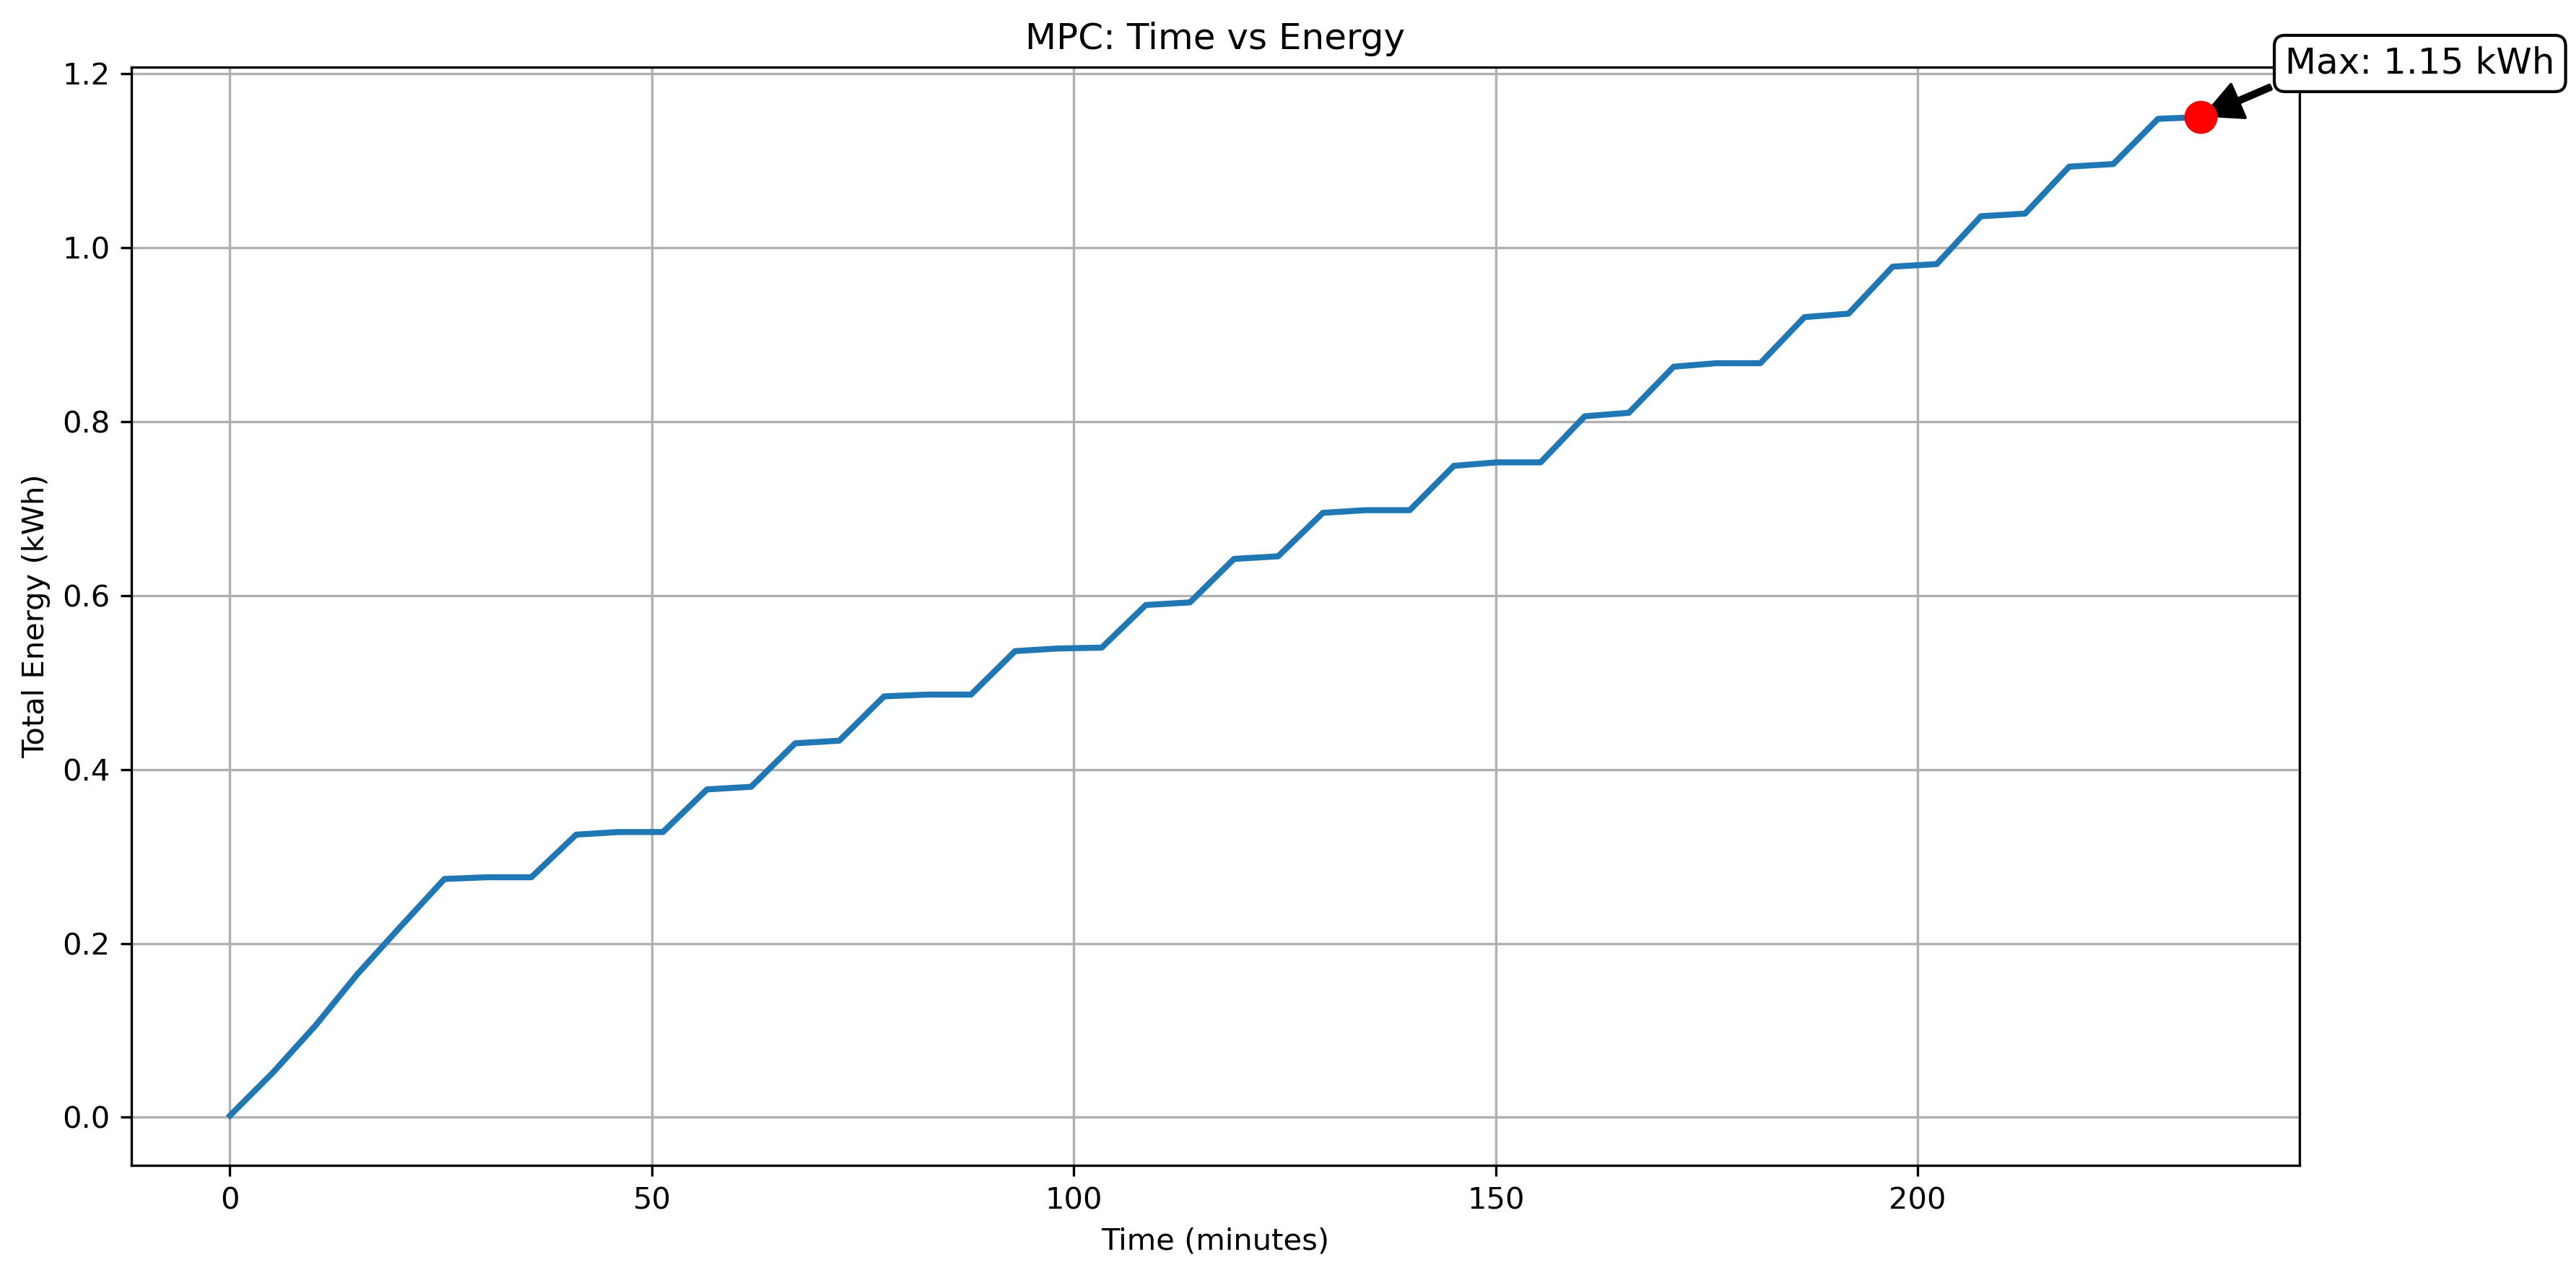

In [19]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import savemat

# Step 1: Define path to folder containing the JSON files
json_folder_path = r'D:\05_05_2025\data\control_actions'

# Step 2: Read all JSON files and normalize into a single DataFrame
all_energy_data = []
for json_file in os.listdir(json_folder_path):
    if json_file.endswith('.json'):
        full_path = os.path.join(json_folder_path, json_file)
        with open(full_path, 'r') as file:
            try:
                json_data = json.load(file)
                json_data['source_file'] = json_file  # Track file origin
                df = pd.json_normalize(json_data)
                all_energy_data.append(df)
            except json.JSONDecodeError:
                print(f"Error decoding {json_file}")

# Combine all data
energy_df = pd.concat(all_energy_data, ignore_index=True)

# Step 3: Parse timestamps and clean
energy_df = energy_df.dropna(subset=['energy_data.timestamp'])
energy_df['timestamp'] = pd.to_datetime(energy_df['energy_data.timestamp'])
energy_df.set_index('timestamp', inplace=True)
energy_df.sort_index(inplace=True)

# Step 4: Define experiment start and end manually (adjust if needed)
experiment_start = pd.to_datetime("2025-05-05 13:38:00")  # <- actual start time
experiment_end = pd.to_datetime("2025-05-05 17:36:46")    # <- 6 hours later

# Filter to 6-hour experiment duration
experiment_df = energy_df.loc[experiment_start:experiment_end]

# Step 5: Convert time to minutes since experiment start
minutes_from_start = (experiment_df.index - experiment_start).total_seconds() / 60

# Step 6: Find max value and its position
max_energy = experiment_df['energy_data.total_energy'].max()
max_time_idx = experiment_df['energy_data.total_energy'].idxmax()
max_time_minutes = (max_time_idx - experiment_start).total_seconds() / 60

# Step 7: Plot with high resolution and mark max value
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(minutes_from_start, experiment_df['energy_data.total_energy'], linewidth=2)

# Add max value point and annotation
plt.scatter(max_time_minutes, max_energy, color='red', s=100, zorder=5)
plt.annotate(f'Max: {max_energy:.2f} kWh', 
             xy=(max_time_minutes, max_energy),
             xytext=(max_time_minutes+10, max_energy+0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1))

plt.title('MPC: Time vs Energy')
plt.xlabel('Time (minutes)')
plt.ylabel('Total Energy (kWh)')
plt.grid(True)
plt.tight_layout()

# Save as PNG file
output_path = os.path.join(os.path.dirname(json_folder_path), 'mpc_energy_plot.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {output_path}")

plt.show()

Plot saved to: D:\05_05_2025\data\mpc_damper_states.png


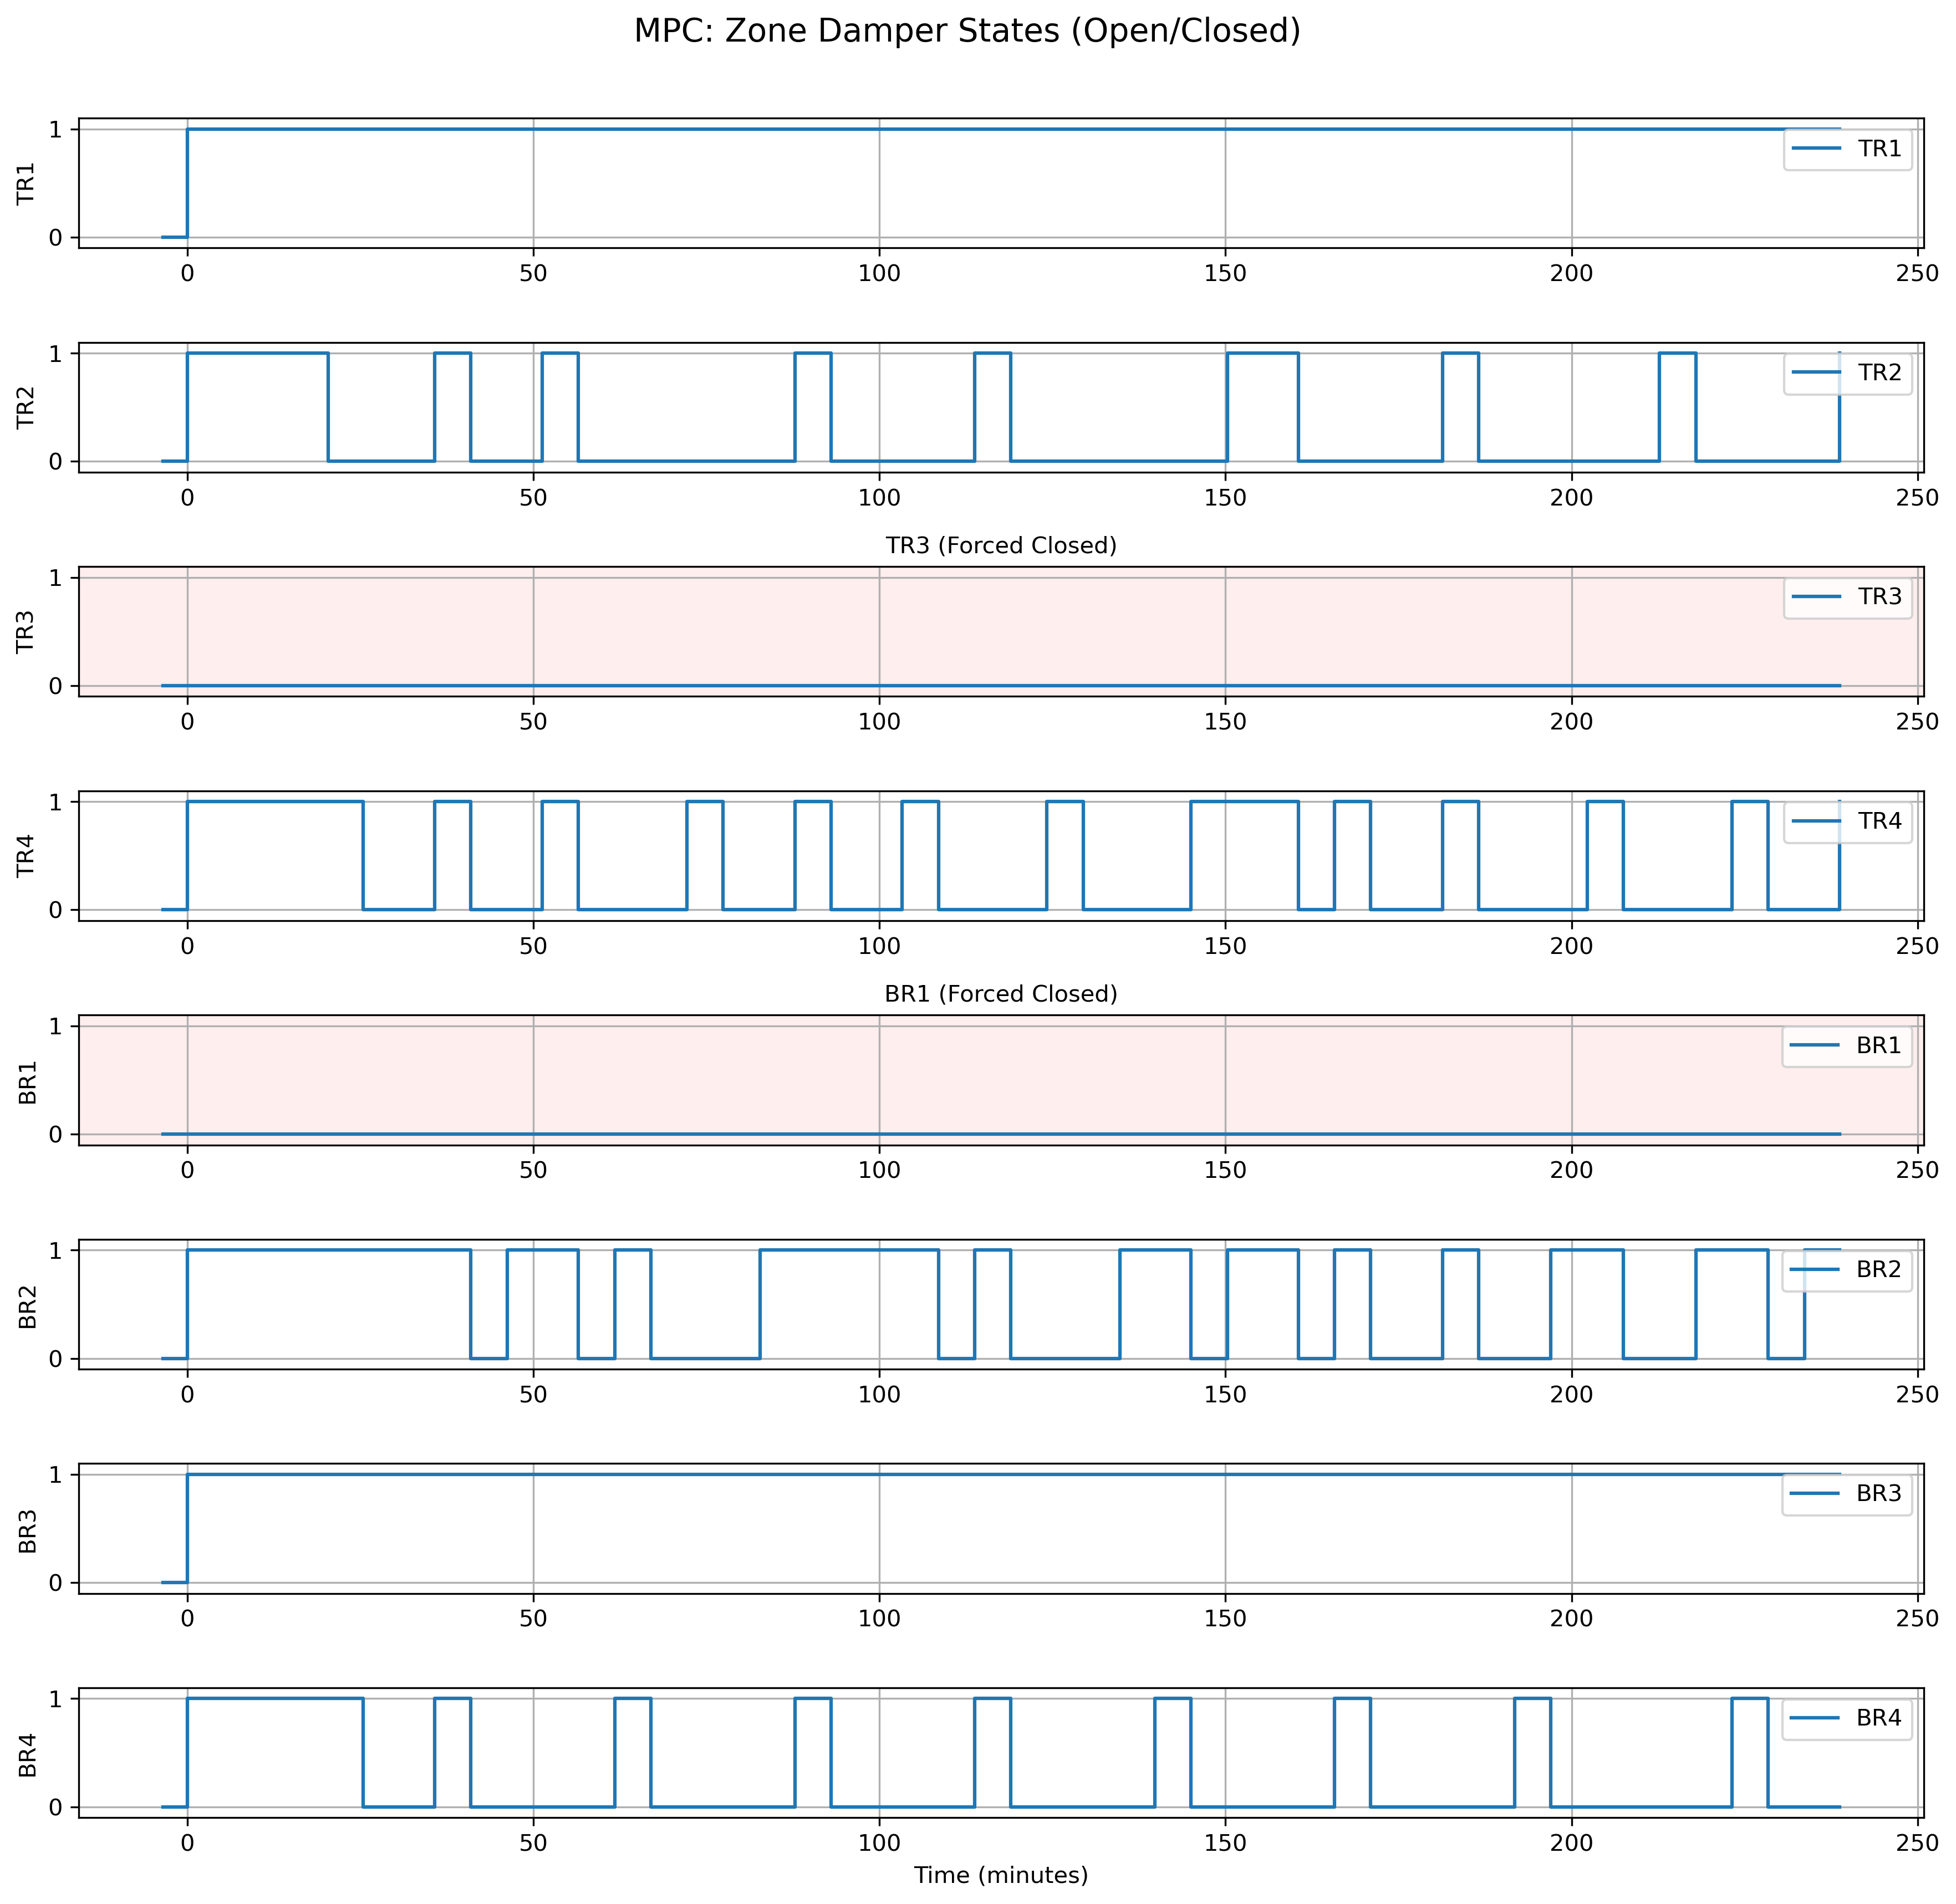

In [22]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
base_folder = r"D:\05_05_2025\data\control_actions"
experiment_start = pd.to_datetime("2025-05-05 13:37:48")
output_path = os.path.join(os.path.dirname(base_folder), 'mpc_damper_states.png')
# ----------------------------

# Correct damper to zone mapping (from hardware_interface.py)
damper_to_zone = {
    0: "TR4",  # Damper 1
    1: "BR4",  # Damper 2
    2: "TR3",  # Damper 3
    3: "BR3",  # Damper 4
    4: "TR2",  # Damper 5
    5: "BR2",  # Damper 6
    6: "TR1",  # Damper 7
    7: "BR1"   # Damper 8
}

# -------- Load Damper Data ----------
damper_records = []
for file in os.listdir(base_folder):
    if file.startswith('dampers_2025-05-05') and file.endswith('.json'):
        file_path = os.path.join(base_folder, file)
        with open(file_path, 'r') as f:
            try:
                data = json.load(f)
                if 'timestamp' in data and 'damper_states' in data:
                    record = {'timestamp': data['timestamp']}
                    
                    # Map each damper state to the correct zone
                    for damper_idx, state in enumerate(data['damper_states']):
                        zone_name = damper_to_zone[damper_idx]
                        record[zone_name] = 1 if state != 0 else 0
                        
                    damper_records.append(record)
            except json.JSONDecodeError:
                print(f"Error decoding {file}")

# -------- Convert to DataFrame ----------
damper_df = pd.DataFrame(damper_records)
damper_df['timestamp'] = pd.to_datetime(damper_df['timestamp'], format='%Y-%m-%d_%H-%M-%S')
damper_df.set_index('timestamp', inplace=True)
damper_df.sort_index(inplace=True)

# Calculate time in minutes since experiment start
damper_df['minutes_since_start'] = (damper_df.index - experiment_start).total_seconds() / 60

# -------- Plot Each Zone in a Subplot ----------
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(12, 12), dpi=300)  # Increased DPI for better quality

# Plot in a specific order for clarity
zone_order = ["TR1", "TR2", "TR3", "TR4", "BR1", "BR2", "BR3", "BR4"]

for i, zone in enumerate(zone_order):
    if zone in damper_df.columns:
        axes[i].step(damper_df['minutes_since_start'], damper_df[zone], where='post', label=zone)
        axes[i].set_ylim(-0.1, 1.1)
        axes[i].set_ylabel(zone)
        axes[i].grid(True)
        axes[i].legend(loc='upper right')
        
        # Highlight the closed zones (TR3 and BR1)
        if zone in ["TR3", "BR1"]:
            axes[i].set_facecolor('#ffeeee')  # Light red background
            axes[i].set_title(f"{zone} (Forced Closed)", fontsize=10)

axes[-1].set_xlabel("Time (minutes)")
fig.suptitle("MPC: Zone Damper States (Open/Closed)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Save figure as PNG
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Plot saved to: {output_path}")

plt.show()